## 3.5 Forma, função e ativação

#### Objetivo:
implemente 3 novas funções de ativação na rede neural feita em Python
puro nos vídeos da disciplina. Escreva brevemente sobre estas 3 funções de ativação,
mostrando a equação delas e comentando a diferença com relação à função de ativação
sigmoidal. Mostre que seu código funciona rodando alguns testes simples.

## Introdução

# 3.5 Forma, função e ativação

Em muitas arquiteturas a função sigmoidal clássica sofre com saturação nos extremos.

$$
\sigma(x) = \frac{1}{1 + e^{-x}}
$$

 Para contornar isso, vamos implementar:

- **ReLU**  
  $$
  \mathrm{ReLU}(x) = \max(0, x)
  $$
- **Tanh**  
  $$
  \tanh(x) = \frac{e^{x} - e^{-x}}{e^{x} + e^{-x}}
  $$
- **PReLU**  
  \[
  \mathrm{PReLU}(x) =
  \begin{cases}
    x, & x \ge 0,\\
    \alpha\,x, & x < 0,
  \end{cases}

  

# 3.5 Forma, função e ativação

Em muitas arquiteturas a função sigmoidal clássica  
\[
\sigma(x) = \frac{1}{1 + e^{-x}}
\]
sofre com saturação nos extremos. Para contornar isso, vamos implementar:

- **ReLU**  
  \[
  \mathrm{ReLU}(x) = \max(0, x)
  \]
- **Tanh**  
  \[
  \tanh(x) = \frac{e^{x} - e^{-x}}{e^{x} + e^{-x}}
  \]
- **PReLU**  
  \[
  \mathrm{PReLU}(x) =
  \begin{cases}
    x, & x \ge 0,\\
    \alpha\,x, & x < 0,
  \end{cases}
  \]
  onde \(\alpha\) é parâmetro aprendível.


In [2]:
import math

class Valor:
    def __init__(self, data, progenitor=(), operador_mae="", rotulo=""):
        self.data = data
        self.progenitor = progenitor
        self.operador_mae = operador_mae
        self.rotulo = rotulo
        self.grad = 0

    def __repr__(self):
        return f"Valor(data={self.data})"
    
    def __add__(self, outro_valor):
        """Realiza a operação: self + outro_valor."""
        
        if not isinstance(outro_valor, Valor):
            outro_valor = Valor(outro_valor)
            
        progenitor = (self, outro_valor)
        data = self.data + outro_valor.data
        operador_mae = "+"
        resultado = Valor(data, progenitor, operador_mae)
        
        def propagar_adicao():
            self.grad += resultado.grad
            outro_valor.grad += resultado.grad
            
        resultado.propagar = propagar_adicao
        
        return resultado
    
    def __mul__(self, outro_valor):
        """Realiza a operação: self * outro_valor."""
        
        if not isinstance(outro_valor, Valor):
            outro_valor = Valor(outro_valor)
            
        progenitor = (self, outro_valor)
        data = self.data * outro_valor.data
        operador_mae = "*"
        resultado = Valor(data, progenitor, operador_mae)
        
        def propagar_multiplicacao():
            self.grad += resultado.grad * outro_valor.data # grad_filho * derivada filho em relação a mãe
            outro_valor.grad += resultado.grad * self.data
            
        resultado.propagar = propagar_multiplicacao
        
        return resultado
    
    def exp(self):
        """Realiza a operação: exp(self)"""
        progenitor = (self, )
        data = math.exp(self.data)
        operador_mae = "exp"
        resultado = Valor(data, progenitor, operador_mae)
        
        def propagar_exp():
            self.grad += resultado.grad * data 
        
        resultado.propagar = propagar_exp
        
        return resultado
    
    def __pow__(self, expoente):
        """Realiza a operação: self ** expoente"""
        assert isinstance(expoente, (int, float))
        progenitor = (self, )
        data = self.data ** expoente
        operador_mae = f"**{expoente}"
        resultado = Valor(data, progenitor, operador_mae)
        
        def propagar_pow():
            self.grad += resultado.grad * (expoente * self.data ** (expoente - 1))
        
        resultado.propagar = propagar_pow
        
        return resultado
    
    def relu(self):
        """Função de ativação ReLU: retorna x se x > 0, senão retorna 0"""
        progenitor = (self,)
        data = self.data if self.data > 0 else 0
        resultado = Valor(data, progenitor, "ReLU")

        def propagar_relu():
            self.grad += resultado.grad * (1 if self.data > 0 else 0)

        resultado.propagar = propagar_relu
        return resultado
    
    def prelu(self, a= 0.1):
        """Função de ativação paramétrica ReLU: retorna x se x > 0, senão a*x"""
        if not isinstance(a, Valor):
            a = Valor(a)

        progenitor = (self, )
        if self.data > 0:
            resultado = Valor(self.data, progenitor, "prelu")

            def propagar_prelu():
                self.grad += resultado.grad  
      

        else:
            resultado = Valor(a.data * self.data, progenitor, "prelu")

            def propagar_prelu():
                self.grad += resultado.grad * a.data  # derivada da multiplicação: a
               

        resultado.propagar = propagar_prelu
        return resultado

    def __truediv__(self, outro_valor):
        """Realiza a operação: self / outro_valor"""
        return self * outro_valor ** (-1)
    
    def __neg__(self):
        """Realiza a operação: -self"""
        return self * -1
    
    def __sub__(self, outro_valor):
        """Realiza a operação: self - outro_valor"""
        return self + (-outro_valor)
    
    def __radd__(self, outro_valor):
        """Realiza a operação: outro_valor + self"""
        return self + outro_valor
    
    def __rmul__(self, outro_valor):
        """Realiza a operação: outro_valor * self"""
        return self * outro_valor
    
    def sig(self):
        """Realiza a operação: exp(self) / (exp(self) + 1)"""
        return self.exp() / (self.exp() + 1)
    
    def tanh(self):
        exp_pos = self.exp()
        exp_neg = (-self).exp()
        return (exp_pos - exp_neg) / (exp_pos + exp_neg)

    def propagar(self):
        pass
    
    def propagar_tudo(self):
        
        self.grad = 1
        
        ordem_topologica = []
        
        visitados = set()

        def constroi_ordem_topologica(v):
            if v not in visitados:
                visitados.add(v)
                for progenitor in v.progenitor:
                    constroi_ordem_topologica(progenitor)
                ordem_topologica.append(v)

        constroi_ordem_topologica(self)
        
        for vertice in reversed(ordem_topologica):
            vertice.propagar()
            


In [3]:
import random
import matplotlib.pyplot as plt

class Neuronio1:
    def __init__(self, num_dados_entrada):
        self.vies = Valor(random.uniform(-1, 1))
        
        self.pesos = []
        for i in range(num_dados_entrada):
            self.pesos.append(Valor(random.uniform(-1, 1)))
            
    def __call__(self, x):
        
        assert len(x) == len(self.pesos)
        
        soma = 0
        for info_entrada, peso_interno in zip(x, self.pesos):
            soma += info_entrada * peso_interno
            
        soma += self.vies  
        dado_de_saida = soma.tanh()
        
        return dado_de_saida       
    
    def parametros(self):
        return self.pesos + [self.vies]

class Camada1:
    def __init__(self, num_neuronios, num_dados_entrada):
        neuronios = []
        
        for _ in range(num_neuronios):
            neuronio = Neuronio1(num_dados_entrada)
            neuronios.append(neuronio)
            
        self.neuronios = neuronios     
        
    def __call__(self, x):
        dados_de_saida = []
        
        for neuronio in self.neuronios:
            informacao = neuronio(x)
            dados_de_saida.append(informacao)
            
        if len(dados_de_saida) == 1:
            return dados_de_saida[0]
        else:        
            return dados_de_saida  
    
    def parametros(self):
        params = []
        
        for neuronio in self.neuronios:
            params_neuronio = neuronio.parametros()
            params.extend(params_neuronio)
        
        return params
    
class MLP1:
    def __init__(self, num_dados_entrada, num_neuronios_por_camada):
        
        percurso = [num_dados_entrada] + num_neuronios_por_camada
        
        camadas = []
        
        for i in range(len(num_neuronios_por_camada)):
            camada = Camada1(num_neuronios_por_camada[i], percurso[i])
            camadas.append(camada)
            
        self.camadas = camadas
        
    def __call__(self, x):
        for camada in self.camadas:
            x = camada(x)
        return x
    
    def parametros(self):
        params = []
        
        for camada in self.camadas:
            parametros_camada = camada.parametros()
            params.extend(parametros_camada)
            
        return params

In [4]:
x = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]

y_true = [1, 0, 0.2, 0.5]

NUM_DADOS_DE_ENTRADA = 3  
NUM_DADOS_DE_SAIDA = 1    
CAMADAS_OCULTAS = [3, 2]  

arquitetura_da_rede = CAMADAS_OCULTAS + [NUM_DADOS_DE_SAIDA]


minha_mlp = MLP1(NUM_DADOS_DE_ENTRADA, arquitetura_da_rede)

In [5]:
NUM_EPOCAS = 200
TAXA_DE_APRENDIZADO = 0.1
perdas1 = []
for epoca in range(NUM_EPOCAS):
    # forward pass
    y_pred = []
    for exemplo in x:
        previsao = minha_mlp(exemplo)
        y_pred.append(previsao)

    # loss
    erros = []
    for yt, yp in zip(y_true, y_pred):
        residuo = yp - yt
        erro_quadratico = residuo ** 2
        erros.append(erro_quadratico)        
    loss = sum(erros)
    perdas1.append(loss.data)


    # zero grad
    for p in minha_mlp.parametros():
        p.grad = 0

    # backpropagation
    loss.propagar_tudo()

    # atualiza parâmetros
    for p in minha_mlp.parametros():
        p.data = p.data - p.grad * TAXA_DE_APRENDIZADO
    
    # mostra resultado (opcional)
    print(epoca, loss.data)

0 0.8423112856048593
1 0.6269247234200644
2 0.5285534830477316
3 0.5230403298731492
4 0.5166756150946765
5 0.5080692208794492
6 0.4951214273155217
7 0.47360858520841587
8 0.43545072688732367
9 0.37182440110887016
10 0.2915467846840091
11 0.21935893518574243
12 0.16698936265443487
13 0.13317400709687768
14 0.11209425520802077
15 0.09873384157023052
16 0.08999195092132804
17 0.0840767831690116
18 0.07991508587752684
19 0.07683385903750393
20 0.0744037171630402
21 0.07235347974495411
22 0.07051617976128936
23 0.06879224479681452
24 0.06712438507461098
25 0.0654810337580619
26 0.06384585984194138
27 0.06221136607276411
28 0.06057509622252955
29 0.05893743862494751
30 0.057300372633047325
31 0.055666756365475495
32 0.0540399178663868
33 0.05242341301125495
34 0.050820873738186105
35 0.04923590503624129
36 0.047672008816072475
37 0.046132523675388455
38 0.044620575438815036
39 0.04313903639303206
40 0.041690492601688264
41 0.04027721927369277
42 0.038901164270499125
43 0.037563939701765456
4

In [6]:
import random

class Neuronio2:
    def __init__(self, num_dados_entrada):
        self.vies = Valor(random.uniform(-1, 1))
        
        self.pesos = []
        for i in range(num_dados_entrada):
            self.pesos.append(Valor(random.uniform(-1, 1)))
            
    def __call__(self, x):
        
        assert len(x) == len(self.pesos)
        
        soma = 0
        for info_entrada, peso_interno in zip(x, self.pesos):
            soma += info_entrada * peso_interno
            
        soma += self.vies  
        dado_de_saida = soma.relu()
        
        return dado_de_saida       
    
    def parametros(self):
        return self.pesos + [self.vies]

class Camada2:
    def __init__(self, num_neuronios, num_dados_entrada):
        neuronios = []
        
        for _ in range(num_neuronios):
            neuronio = Neuronio2(num_dados_entrada)
            neuronios.append(neuronio)
            
        self.neuronios = neuronios     
        
    def __call__(self, x):
        dados_de_saida = []
        
        for neuronio in self.neuronios:
            informacao = neuronio(x)
            dados_de_saida.append(informacao)
            
        if len(dados_de_saida) == 1:
            return dados_de_saida[0]
        else:        
            return dados_de_saida  
    
    def parametros(self):
        params = []
        
        for neuronio in self.neuronios:
            params_neuronio = neuronio.parametros()
            params.extend(params_neuronio)
        
        return params
    
class MLP2:
    def __init__(self, num_dados_entrada, num_neuronios_por_camada):
        
        percurso = [num_dados_entrada] + num_neuronios_por_camada
        
        camadas = []
        
        for i in range(len(num_neuronios_por_camada)):
            camada = Camada2(num_neuronios_por_camada[i], percurso[i])
            camadas.append(camada)
            
        self.camadas = camadas
        
    def __call__(self, x):
        for camada in self.camadas:
            x = camada(x)
        return x
    
    def parametros(self):
        params = []
        
        for camada in self.camadas:
            parametros_camada = camada.parametros()
            params.extend(parametros_camada)
            
        return params

In [7]:
x = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]

y_true = [1, 0, 0.2, 0.5]

NUM_DADOS_DE_ENTRADA = 3  
NUM_DADOS_DE_SAIDA = 1    
CAMADAS_OCULTAS = [3, 2]  

arquitetura_da_rede = CAMADAS_OCULTAS + [NUM_DADOS_DE_SAIDA]


minha_mlp = MLP2(NUM_DADOS_DE_ENTRADA, arquitetura_da_rede)

In [8]:
NUM_EPOCAS = 200
TAXA_DE_APRENDIZADO = 0.1
perdas2 = []
for epoca in range(NUM_EPOCAS):
    # forward pass
    y_pred = []
    for exemplo in x:
        previsao = minha_mlp(exemplo)
        y_pred.append(previsao)

    # loss
    erros = []
    for yt, yp in zip(y_true, y_pred):
        residuo = yp - yt
        erro_quadratico = residuo ** 2
        erros.append(erro_quadratico)        
    loss = sum(erros)
    perdas2.append(loss.data)

    # zero grad
    for p in minha_mlp.parametros():
        p.grad = 0

    # backpropagation
    loss.propagar_tudo()

    # atualiza parâmetros
    for p in minha_mlp.parametros():
        p.data = p.data - p.grad * TAXA_DE_APRENDIZADO

    # mostra resultado (opcional)
    print(epoca, loss.data)

0 0.7560828735173986
1 0.5733830756349136
2 0.5677353230253965
3 0.567509412921016
4 0.5675003765168407
5 0.5675000150606736
6 0.5675000006024269
7 0.5675000000240971
8 0.5675000000009638
9 0.5675000000000385
10 0.5675000000000016
11 0.5675
12 0.5674999999999999
13 0.5675
14 0.5675
15 0.5675000000000001
16 0.5674999999999999
17 0.5674999999999998
18 0.5675000000000001
19 0.5675000000000001
20 0.5675
21 0.5675
22 0.5675
23 0.5675
24 0.5675
25 0.5675
26 0.5675
27 0.5675
28 0.5675
29 0.5675
30 0.5675
31 0.5675
32 0.5675
33 0.5675
34 0.5675
35 0.5675
36 0.5675
37 0.5675
38 0.5675
39 0.5675
40 0.5675
41 0.5675
42 0.5675
43 0.5675
44 0.5675
45 0.5675
46 0.5675
47 0.5675
48 0.5675
49 0.5675
50 0.5675
51 0.5675
52 0.5675
53 0.5675
54 0.5675
55 0.5675
56 0.5675
57 0.5675
58 0.5675
59 0.5675
60 0.5675
61 0.5675
62 0.5675
63 0.5675
64 0.5675
65 0.5675
66 0.5675
67 0.5675
68 0.5675
69 0.5675
70 0.5675
71 0.5675
72 0.5675
73 0.5675
74 0.5675
75 0.5675
76 0.5675
77 0.5675
78 0.5675
79 0.5675
80 0.56

In [9]:
import random

class Neuronio3:
    def __init__(self, num_dados_entrada):
        self.vies = Valor(random.uniform(-1, 1))
        
        self.pesos = []
        for i in range(num_dados_entrada):
            self.pesos.append(Valor(random.uniform(-1, 1)))
            
    def __call__(self, x):
        
        assert len(x) == len(self.pesos)
        
        soma = 0
        for info_entrada, peso_interno in zip(x, self.pesos):
            soma += info_entrada * peso_interno
            
        soma += self.vies  
        dado_de_saida = soma.prelu()
        
        return dado_de_saida       
    
    def parametros(self):
        return self.pesos + [self.vies]

class Camada3:
    def __init__(self, num_neuronios, num_dados_entrada):
        neuronios = []
        
        for _ in range(num_neuronios):
            neuronio = Neuronio3(num_dados_entrada)
            neuronios.append(neuronio)
            
        self.neuronios = neuronios     
        
    def __call__(self, x):
        dados_de_saida = []
        
        for neuronio in self.neuronios:
            informacao = neuronio(x)
            dados_de_saida.append(informacao)
            
        if len(dados_de_saida) == 1:
            return dados_de_saida[0]
        else:        
            return dados_de_saida  
    
    def parametros(self):
        params = []
        
        for neuronio in self.neuronios:
            params_neuronio = neuronio.parametros()
            params.extend(params_neuronio)
        
        return params
    
class MLP3:
    def __init__(self, num_dados_entrada, num_neuronios_por_camada):
        
        percurso = [num_dados_entrada] + num_neuronios_por_camada
        
        camadas = []
        
        for i in range(len(num_neuronios_por_camada)):
            camada = Camada3(num_neuronios_por_camada[i], percurso[i])
            camadas.append(camada)
            
        self.camadas = camadas
        
    def __call__(self, x):
        for camada in self.camadas:
            x = camada(x)
        return x
    
    def parametros(self):
        params = []
        
        for camada in self.camadas:
            parametros_camada = camada.parametros()
            params.extend(parametros_camada)
            
        return params

Colocar as funções matemáticas de ativação na introdução
guiar leitor 
introd e conclusão

Posso colocar mais de uma função na rede ?

tanh()	Melhor que sigmoid para camadas ocultas, pois é centrada em 0 e tem gradientes mais fortes

relu()	Mais simples e rápida, mas pode "morrer" com dados negativos

prelu()	Funciona bem como relu, mas com parte negativa controlada — pode ser interessante

In [10]:
x = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]

y_true = [1, 0, 0.2, 0.5]

NUM_DADOS_DE_ENTRADA = 3  
NUM_DADOS_DE_SAIDA = 1    
CAMADAS_OCULTAS = [3, 2]  

arquitetura_da_rede = CAMADAS_OCULTAS + [NUM_DADOS_DE_SAIDA]


minha_mlp = MLP3(NUM_DADOS_DE_ENTRADA, arquitetura_da_rede)

In [11]:
NUM_EPOCAS = 200
TAXA_DE_APRENDIZADO = 0.1
perdas3 = []
for epoca in range(NUM_EPOCAS):
    # forward pass
    y_pred = []
    for exemplo in x:
        previsao = minha_mlp(exemplo)
        y_pred.append(previsao)

    # loss
    erros = []
    for yt, yp in zip(y_true, y_pred):
        residuo = yp - yt
        erro_quadratico = residuo ** 2
        erros.append(erro_quadratico)        
    loss = sum(erros)
    perdas3.append(loss.data)

    # zero grad
    for p in minha_mlp.parametros():
        p.grad = 0

    # backpropagation
    loss.propagar_tudo()

    # atualiza parâmetros
    for p in minha_mlp.parametros():
        p.data = p.data - p.grad * TAXA_DE_APRENDIZADO

    # mostra resultado (opcional)
    print(epoca, loss.data)

0 1.8286674070559645
1 1.3382507934228003
2 1.010593637134844
3 0.5453680192046683
4 0.5299879548776563
5 0.5175134317471745
6 0.5005924455165564
7 0.4772412899457934
8 0.4447063484905781
9 0.4169288257123991
10 0.38833040280396647
11 0.35903565666153064
12 0.3328997139834433
13 0.31162171386470644
14 0.27437215954427024
15 0.2429483059393624
16 0.21260358914363134
17 0.18398377119934275
18 0.15759043333391365
19 0.13375476258696756
20 0.11585456151765533
21 0.13304219276722107
22 0.09697024942544195
23 0.07802203358353182
24 0.06422470574210036
25 0.05312768264454657
26 0.04914121819669347
27 0.07726177911086476
28 0.052036377275233775
29 0.10623486520642153
30 0.059545892602590904
31 0.03597515834048737
32 0.02624534257480317
33 0.020565709423008408
34 0.022574390351185244
35 0.04050543897018268
36 0.036111435913737985
37 0.07883740207002175
38 0.056481835893481824
39 0.12628870530638855
40 0.08191396433345052
41 0.17755237989209885
42 0.10780271268177832
43 0.2190442193553802
44 0.1

In [12]:
perdas2

[0.7560828735173986,
 0.5733830756349136,
 0.5677353230253965,
 0.567509412921016,
 0.5675003765168407,
 0.5675000150606736,
 0.5675000006024269,
 0.5675000000240971,
 0.5675000000009638,
 0.5675000000000385,
 0.5675000000000016,
 0.5675,
 0.5674999999999999,
 0.5675,
 0.5675,
 0.5675000000000001,
 0.5674999999999999,
 0.5674999999999998,
 0.5675000000000001,
 0.5675000000000001,
 0.5675,
 0.5675,
 0.5675,
 0.5675,
 0.5675,
 0.5675,
 0.5675,
 0.5675,
 0.5675,
 0.5675,
 0.5675,
 0.5675,
 0.5675,
 0.5675,
 0.5675,
 0.5675,
 0.5675,
 0.5675,
 0.5675,
 0.5675,
 0.5675,
 0.5675,
 0.5675,
 0.5675,
 0.5675,
 0.5675,
 0.5675,
 0.5675,
 0.5675,
 0.5675,
 0.5675,
 0.5675,
 0.5675,
 0.5675,
 0.5675,
 0.5675,
 0.5675,
 0.5675,
 0.5675,
 0.5675,
 0.5675,
 0.5675,
 0.5675,
 0.5675,
 0.5675,
 0.5675,
 0.5675,
 0.5675,
 0.5675,
 0.5675,
 0.5675,
 0.5675,
 0.5675,
 0.5675,
 0.5675,
 0.5675,
 0.5675,
 0.5675,
 0.5675,
 0.5675,
 0.5675,
 0.5675,
 0.5675,
 0.5675,
 0.5675,
 0.5675,
 0.5675,
 0.5675,
 0.56

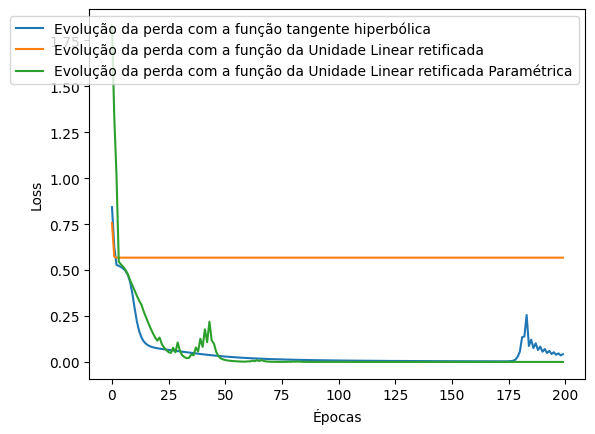

In [13]:
NUM_EPOCAS = 200

plt.plot( perdas1, label= "Evolução da perda com a função tangente hiperbólica")
plt.plot( perdas2, label= "Evolução da perda com a função da Unidade Linear retificada")
plt.plot( perdas3, label= "Evolução da perda com a função da Unidade Linear retificada Paramétrica")

plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.legend()
plt.show()


## Referências

- [datacamp](https://www.datacamp.com/pt/tutorial/introduction-to-activation-functions-in-neural-networks)
- [youtube](https://www.youtube.com/watch?v=XGZNUX2l4fo&t=33s)